# Navier-Stokes: Lid-driven Cavity Flow

---

This notbook solves a special case of the Navier-Stokes equations, the lid-driven cavity flow. More precisely the lid driven cavity with a flexible bottom surface It is an important system for the study of incompressible flows and it is also used as an benchmark for numerical methods. The following example was taken from [Ghia et al. 1982](https://doi.org/10.1016/0021-9991(82)90058-4).

Considering the Navier-Stokes equation: 

$$\mathbf{u}\cdot\nabla \mathbf{u}=-\nabla p + \frac{1}{Re}\Delta \mathbf{u}$$

and the continuity equation:

$$\nabla \cdot \mathbf{u}=0,$$ 

Let $Re=100$, $\mathbf{u}=(u,v)$ the velocity vector field and $p$ the pressure. 

The domain is the rectangle $[0,1]^2$ with the following Dirichlet boundary conditions:

$$
u(0,y)=u(x,0)=u(1,y)=v(0,y)=v(x,0)=v(1,y)=v(x,1)=0
$$

$$
u(x,1)=1
$$

And finally the initial condition for the pressure:

$$
p(0,0)=0
$$



In [1]:
import numpy as np
import torch
import os

# Set torch as the backend for DeepXDE
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Increases floating point precision
dde.config.set_default_float('float64')


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


In [2]:
# Coeficients and domain limits

Re = 100

x0, xf = 0, 1
y0, yf = 0, 1

In [3]:

def cavity_flow_2D_pde(x, U):
    """
    2D cavity flow loss function.
    """

    u_vel, v_vel, p = U[:, 0:1], U[:, 1:2], U[:, 2:]

    du_x = dde.grad.jacobian(U, x, i=0, j=0)
    du_y = dde.grad.jacobian(U, x, i=0, j=1)
    
    du_xx = dde.grad.hessian(U, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(U, x, component=0, i=1, j=1)

    dv_x = dde.grad.jacobian(U, x, i=1, j=0)
    dv_y = dde.grad.jacobian(U, x, i=1, j=1)
    
    dv_xx = dde.grad.hessian(U, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(U, x, component=1, i=1, j=1)

    dp_x = dde.grad.jacobian(U, x, i=2, j=0)
    dp_y = dde.grad.jacobian(U, x, i=2, j=1)

    return [
        # x momentum
        u_vel * dv_x + v_vel * dv_y + dp_y - (1 / Re) * (dv_xx + dv_yy),

        # y momentum
        u_vel * du_x + v_vel * du_y + dp_x - (1 / Re) * (du_xx + du_yy),

        # continuity
        du_x + dv_y
    ]
    

In [4]:

# Define space domain
geom = dde.geometry.Rectangle([x0, y0], [xf, yf])

# define as quatro fronteiras do quadrado
def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)

def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)

def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)

# Velocity boundary condtions for u
u_t_bc = dde.icbc.DirichletBC(geom, lambda x: 1, boundary_top, component=0)
u_r_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=0)
u_l_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=0)
u_b_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)

# Velocity boundary condtions for v
v_t_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_top, component=1)
v_r_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=1)
v_l_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=1)
v_b_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)

# Pressure boundary condition
# https://github.com/lululxvi/deepxde/discussions/1432
p_o_bc = dde.icbc.PointSetBC([[0,0]], [0], component=2)

# Combining all boundary conditions
bc = [u_t_bc, u_r_bc, u_l_bc, u_b_bc, v_t_bc, v_r_bc, v_l_bc, v_b_bc, p_o_bc]


Compiling model...
'compile' took 0.012408 s

Training model...

0         [2.33e-04, 1.01e-01, 1.15e-03, 5.53e-01, 1.94e-02, 2.77e-02, 4.80e-05, 1.54e-02, 3.03e-02, 1.10e-03, 7.94e-03, 0.00e+00]    [2.15e-04, 1.01e-01, 1.03e-03, 5.53e-01, 1.94e-02, 2.77e-02, 4.80e-05, 1.54e-02, 3.03e-02, 1.10e-03, 7.94e-03, 0.00e+00]    []  
300       [1.87e-04, 1.50e-03, 1.00e-02, 1.29e-01, 9.59e-02, 9.96e-02, 1.35e-02, 4.66e-05, 7.42e-06, 6.07e-05, 5.22e-05, 6.03e-07]    [1.61e-04, 1.19e-03, 8.71e-03, 1.29e-01, 9.59e-02, 9.96e-02, 1.35e-02, 4.66e-05, 7.42e-06, 6.07e-05, 5.22e-05, 6.03e-07]    []  

Best model at step 300:
  train loss: 3.50e-01
  test loss: 3.48e-01
  test metric: []

'train' took 41.426866 s



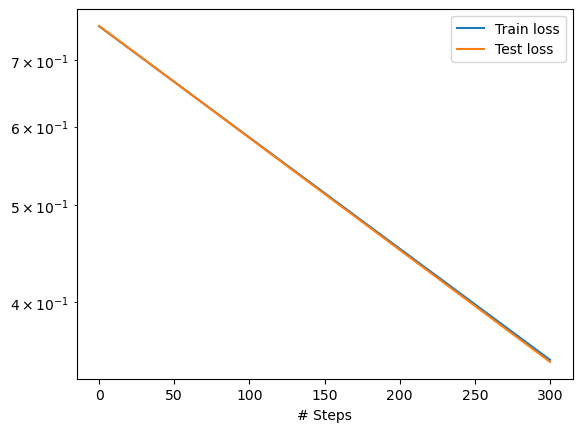

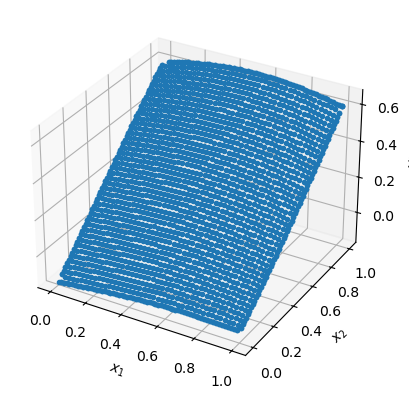

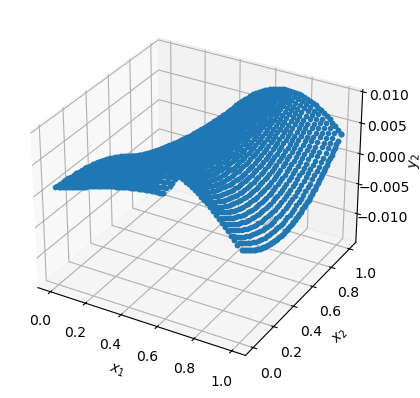

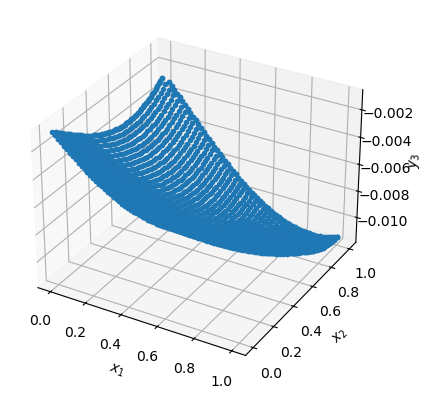

In [6]:

# Ceate training data points
data = dde.data.PDE(
    geom,
    cavity_flow_2D_pde,
    bc,
    num_domain=1800,
    num_boundary=250,
    num_test=1800,
)

# 4 hidden layers with 125 nodes each + hyperbolic tangent activation function + glorot normal initializer
net = dde.nn.FNN([2] + 4 * [125] + [3], "tanh", "Glorot normal")

model = dde.Model(data, net)

# Adam optimizer + 0.0001 leraning rate
model.compile("adam", lr=1e-4)

resampler = dde.callbacks.PDEPointResampler(period=100)

losshistory, train_state = model.train(iterations=300, callbacks=[resampler])

#dde.optimizers.set_LBFGS_options()

#model.compile("L-BFGS")

#losshistory, train_state = model.train(callbacks=[resampler], model_save_path="../models/cavityflow.ckpt")

dde.saveplot(losshistory, train_state, issave=False, isplot=True)


In [ ]:
losshistory, train_state = model.train(iterations=300, callbacks=[resampler])

#dde.optimizers.set_LBFGS_options()

#model.compile("L-BFGS")

#losshistory, train_state = model.train(callbacks=[resampler], model_save_path="../models/cavityflow.ckpt")

dde.saveplot(losshistory, train_state, issave=False, isplot=True)


In [ ]:
model = 

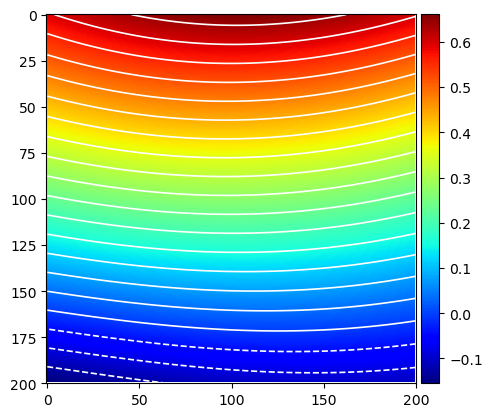

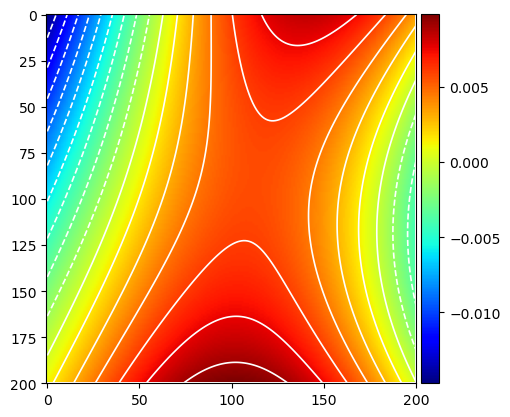

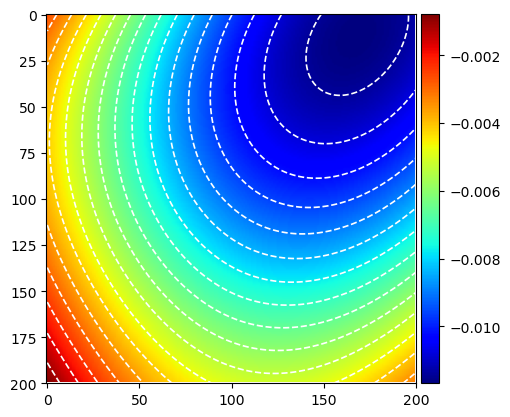

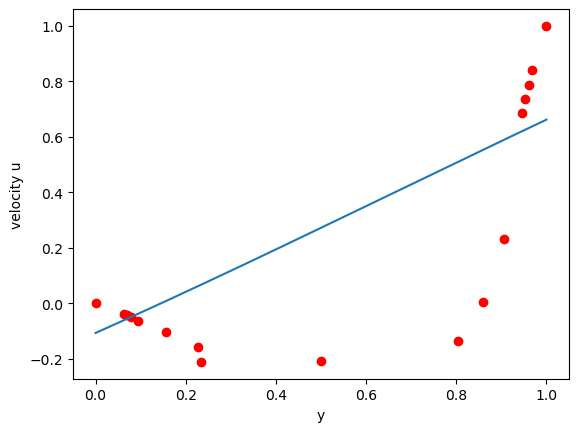

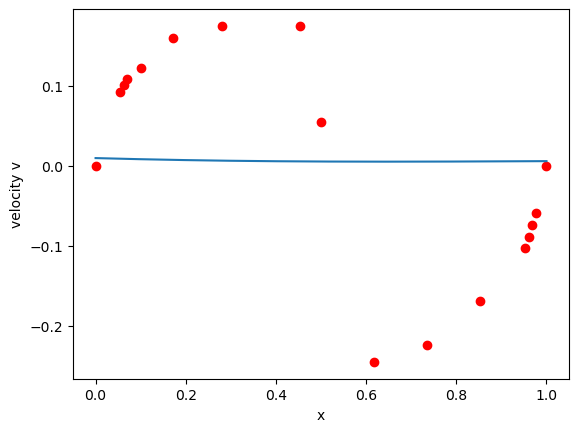

In [14]:
# Testing the model and visualinzg results

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

nop = 200

Nx = nop
Ny = nop

plot_grid = np.mgrid[x0 : xf : Nx * 1j, y0 : yf : Ny * 1j]

points = np.vstack(
    (plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size))
)

W = model.predict(points[:2, :].T)

u = W[:, 0:1].reshape((Nx, Ny))
v = W[:, 1:2].reshape((Nx, Ny))
p = W[:, 2:].reshape((Nx, Ny))

matrix_U = np.fliplr(u).T
matrix_V = np.fliplr(v).T
matrix_p = np.fliplr(p).T


# Visualizing u velocity
fig, (ax1) = plt.subplots(1, 1)
im1 = ax1.imshow(matrix_U, cmap='jet')
ax1.contour(plot_grid[1] * Ny, plot_grid[0] * Nx, matrix_U, levels=20, colors='white', linewidths=1.2)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
plt.savefig("../figures/ns-vel-u.png")


# Visualizing v velocity
fig, (ax2) = plt.subplots(1, 1)
im2 = ax2.imshow(matrix_V, cmap='jet')
ax2.contour(plot_grid[1] * Ny, plot_grid[0] * Nx, matrix_V, levels=20, colors='white', linewidths=1.2)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
plt.savefig("../figures/ns-vel-v.png")


# Visualizing pressure
fig, (ax3) = plt.subplots(1, 1)
im3 = ax3.imshow(matrix_p, cmap='jet')
ax3.contour(plot_grid[1] * Ny, plot_grid[0] * Nx, matrix_p, levels=20, colors='white', linewidths=1.2)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)
plt.savefig("../figures/ns-press-p.png")


# Ghia et al. (1982) benchmark values for Re = 100
ghiau_bechmark = np.loadtxt("../benchmarks/ghiau.txt")
ghiav_bechmark = np.loadtxt("../benchmarks/ghiav.txt")
ref_x, ref_v =  ghiav_bechmark[:, 0:1], ghiav_bechmark[:, 1:2]
ref_y, ref_u =  ghiau_bechmark[:, 0:1], ghiau_bechmark[:, 1:2]


# Velocity u bechmark
fig, (ax4) = plt.subplots(1, 1)
ax4.plot(ref_x, ref_u, 'ro', plot_grid[1, int(nop/2), :], u[int(nop/2), :])
plt.xlabel("y")
plt.ylabel("velocity u")
plt.savefig("../figures/benchmark-vel-u.png")


# Velocity v bechmark
fig, (ax4) = plt.subplots(1, 1)
ax4.plot(ref_y, ref_v, 'ro', plot_grid[1, int(nop/2), :], v[int(nop/2), :])
plt.xlabel("x")
plt.ylabel("velocity v")
plt.savefig("../figures/benchmark-vel-v.png")


plt.show()

## Bibliography

Ghia, Ghia, Shin. High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method, Journal of Computational Physics, Vol. 48, 387-411, 1982.